# Create a parallelogram and break it into a set of domains with randomized, smooth boundaries. 


In [2]:
#*************************************************************************************************************************#
#*************************************************** Importing modules ***************************************************#
#*************************************************************************************************************************#


import numpy as np
import matplotlib.pyplot as plt
import collections.abc
import random
from shapely.geometry import Polygon, MultiPolygon
from descartes import PolygonPatch
import timeit
import datetime
import os
from pathlib import Path
import dill


In [3]:
#***************************************************************************************************************#
#********************** Create the sample, break it into domains and extract the polygons **********************#
#***************************************************************************************************************#

def evaluate_gaussian(distance, sigma = 1.):

    """ Evaluates a Gaussian at a given distance centered at x = 0.
    
    Parameters:
    -----------
    distance: float
        length of the translation vector
    sigma: float
        standard deviation
        
    Returns:
    --------
    output: float
        Value of the Gaussian 
    """ 
    

    return np.exp(- (distance**2) / (2 * sigma ** 2)) / (np.sqrt(2 * np.pi) * sigma) 

def get_distance(position_1, position_2):

    """ Calculates the distance between two points.
    
    Parameters:
    -----------
    position_1, position_2: 1D list or 1D NumPy array
        coordinates of the positions
    
    Returns:
    --------
    output: float
        Distance between the points
    """ 
    

    position_1 = np.array(position_1)
    position_2 = np.array(position_2)
    translation_vector = position_1 - position_2
    return np.sqrt(np.dot(translation_vector, translation_vector))

def add_gaussian_to_grid(x_grid, y_grid, z_grid, gaussian_center, sigma = 1.):


    """ Adds the values of a Gaussian to a meshgrid.
    
    Parameters:
    -----------
    x_grid, y_grid, z_grid: 2D NumPy array
        X,Y and Z meshgrids
    gaussian_center: 1D list or 1D NumPy array
        position of the Gaussian
    sigma: float
        standard deviation of the Gaussian
        
    Returns:
    --------
    zgrid: 2D NumPy array
        updated Z meshgrid
    """ 
    
    if np.shape(x_grid) != np.shape(y_grid):
        raise ValueError('The shape of x_grid is no the same as that of y_grid!')

    z_grid = np.array(z_grid)
    z_grid_temp = np.zeros(np.shape(x_grid))
    
    if np.shape(z_grid) != np.shape(z_grid_temp):
        raise ValueError('The shape of z_grid is no the same as that of x_grid and y_grid!')
    
    for i,x in enumerate(x_grid[0]):
        for j,y in enumerate(y_grid[:,0]):
            z_grid_temp[j,i] = evaluate_gaussian(get_distance(position_1 = [x, y], position_2 = gaussian_center), sigma)

    return z_grid + z_grid_temp

def get_polygon_vertices(sample_start, sample_length, sample_width, angle):

    """ Extract the coordinates of the polygon vertices of a sample.
    
    Parameters:
    -----------
    sample_start: 1D list or 1D numpy array
        coordinates of the bottom left vertix of the polygon
    sample_length: float
        length of the polygon
    sample_width: float
        width of the polygon
    angle: float
        angle in radians between the length and width vectors (angle = 0 implies a rectangular sample)
        
    Returns:
    --------
    sample_vertices: 2D list
        x and y coordinates of the vertices of the polygon with the following order:
        
                           4 -------------- 3
                          /                /
                         /                /
                       1,5 ------------- 2
                        
    """ 
    sample_vertices =  [[0., sample_length, 
                         sample_length + (sample_width * np.tan(angle)),
                         sample_width * np.tan(angle), 0.],
                        [0., 0., sample_width, sample_width, 0.]]

    sample_vertices[0] = [ x + sample_start[0] for x in sample_vertices[0]]
    sample_vertices[1] = [ x + sample_start[1] for x in sample_vertices[1]]
    
    return sample_vertices


def generate_gaussian_centers(n_gauss, sample_vertices):

    """ Generates random coordinates inside a polygon given the polygon vertices.
    
    Parameters:
    -----------
    n_gauss: int
        number of Gaussians.

    sample_vertices: 2D list 
        x and y coordinates of the vertices of the polygon. The order of the vertices is important,
        it should be the same as in the output of function get_polygon_vertices
        
    Returns:
    --------
    gaussian_centers_list: 2D list
        the list of coordinates of the centers
    """ 
        
    x0, y0 = sample_vertices[0][0], sample_vertices[1][0]
    sample_length = sample_vertices[0][1] - sample_vertices[0][0]
    sample_width = sample_vertices[1][2] - sample_vertices[0][0]
    x_displacement = sample_vertices[0][3] - sample_vertices[0][0]
    
    gaussian_centers_list = []
    
    for i_gauss in range(n_gauss):

        x_rand, y_rand = random.uniform(0, 1), random.uniform(0, 1)
        y_temp = y0 + sample_width * y_rand
        x_temp = x0 + (sample_length  *  x_rand) + (x_displacement * y_temp / sample_width) 

        gaussian_centers_list.append([x_temp, y_temp])
        
    return gaussian_centers_list

def get_grids(x_range, y_range, precision  = 1.):
    
    """ Convert x, y ranges to X, Y and Z meshgrids.
    
    Parameters:
    -----------
    x_range, y_range: 1D lists or NumPy arrays
        Initial and final points in length (x_range) and width(y_range) of the grids
    precision: float
        Multiplier of the length and width to obtain the number of points in the grids (which will be isotropic). 
        Example: if the length is 20,the width 10 and the precision 2 then the grids will have 40x20 points.

        
    Returns:
    --------
    X,Y and Z: NumPy meshgrids
    """ 
    
    
    xi, xf = x_range
    yi, yf = y_range
    
    Nx = int((xf - xi) * precision)
    Ny = int((yf - yi) * precision)
    
    x_linspace = np.linspace(xi, xf, Nx)
    y_linspace = np.linspace(yi, yf, Ny)

    x_grid, y_grid = np.meshgrid(x_linspace, y_linspace, indexing = 'xy')
    z_grid = np.zeros(np.shape(x_grid))
    
    return x_grid, y_grid, z_grid

def get_contour_paths(x_grid, y_grid, z_grid, contour_level):
    
    """ Get the set of contour paths.
    
    Parameters:
    -----------
    x_grid, y_grid, z_grid: NumPy arrays
        X, Y and Z grids
    contour_level: float
        Value of the contour level to divide the sample
        
    Returns:
    --------
    contour_set.collections[0].get_paths(): list of paths
        contour set collection. The first item contains the Paths
    """ 
    
    fig, ax = plt.subplots()
    contour_set = ax.contour(x_grid, y_grid, z_grid, levels = [contour_level])    
    plt.close()
    
    return contour_set.collections[0].get_paths()
    
    
def get_polygons_in_sample(contour_paths, sample_polygon, break_residue = False):
    
    """ Extracts the polygons of the domains in the sample.
    
    Parameters:
    -----------
    contour_paths: matplotlib Paths
        contours of the domains
    sample_polygon: shapely Polygon
        sample 
    break_residue: bool
        if set to True it will break the reside domain into subdomains that 
        
    Returns:
    --------
    polygons: 1D list
        array of shapely polygons of the contours
    """
    
    contour_paths_vertices = []
    polygons = []
    sample_polygon_residue = sample_polygon
    
    for contour_path in contour_paths:
        contour_vertices = contour_path.vertices
        
        try:
            polygon = Polygon(contour_vertices).intersection(sample_polygon)
            if not polygon.is_empty:
                polygons.append(polygon)
                sample_polygon_residue = sample_polygon_residue.difference(polygon)
            
        except Exception as error: 
            print('Error: ', error)
            
    if not break_residue:
        polygons.append(sample_polygon_residue)
        return polygons
            
    if isinstance(sample_polygon_residue, MultiPolygon):
        for polygon in sample_polygon_residue:
            polygons.append(polygon)
    else:
        polygons.append(sample_polygon_residue)
        
    return polygons

def delete_inner_polygons(polygons):
    
    """ Deletes polygons that are fully contained within other polygons in a list.
    
    Parameters:
    -----------
    polygons: 1D list
        array of shapely polygons 
        
    Returns:
    --------
    fixed_polygon: updated list 
    
    """
    
    fixed_polygons = []
    for i, polygon1 in enumerate(polygons):
        is_it_inner = False
        for j, polygon2 in enumerate(polygons):
            if i == j:
                break
            if polygon1 == polygon1.intersection(polygon2):
                is_it_inner = True
                break
        if not is_it_inner:
            fixed_polygons.append(polygon1)
                
    return fixed_polygons

def plot_polygons(polygons, **kwargs):
    
    """ Plots an array of polygons.
    
    Parameters:
    -----------
    polygons: 1D list
        array containing the polygons to be plotted
    kwargs: dict
        plot keyword arguments
    """
        

    if not isinstance(polygons, list):
        polygons = [polygons]
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color'] 
    
    figsize = kwargs['figsize'] if 'figsize' in kwargs else (20, 4)
    xlim = kwargs['xlim'] if 'xlim' in kwargs else None
    ylim = kwargs['ylim'] if 'ylim' in kwargs else None
    
    fig, ax = plt.subplots(figsize = figsize)
    polygons.reverse()
    
    for i, polygon in enumerate(polygons):

        if type(polygon) == MultiPolygon:
            for sub_polygon in list(polygon.geoms):
                patch = PolygonPatch(sub_polygon, fc = colors[i%10], alpha=0.5, zorder=1)
                ax.add_patch(patch)
            continue
        patch = PolygonPatch(polygon, fc = colors[i%10], alpha=0.5, zorder=1) 
        ax.add_patch(patch)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    plt.show()
    plt.close()

def get_mean_std(stds):
    
    """ Calculates the mean standard deviation of an array of (independent) standard deviations.
    
    Parameters:
    -----------
    stds: 1D list of float objects
        array of standard deviations

    Returns:
    --------
    std_mean: float
        mean standard deviation
    """
    std_mean = 0
    
    for std in stds:
        std_mean += std ** 2
        
    std_mean /= len(stds)
    std_mean = np.sqrt(std_mean)
    
    return std_mean

# Generate an ensemble of samples

In [4]:
#****************************************************************************************************************#
#********************************************** Generate ensembles **********************************************#
#****************************************************************************************************************#


def get_polygons_ensemble(N_samples = 1, fix_n_domains = True, min_domain_area = -1, n_errors_tol = 0, seed = None,\
                          timer = False, **kwargs):
    
    """ Generate an ensemble of samples, ie of lists containing the shapely polygons that make up the sample.
    
    Parameters:
    -----------
    N_samples: int
        Number of samples of the ensemble
    fix_n_domains: bool
        If set to True it forces the number of domains to be equal to kwargs['n_domains']. 
        ************ Warning: If the parameters are not reasonable this will run forever ***********
    min_domain_area: float
        Minimum domain area of the polygons in the sample
        ************ Warning: If the parameters are not reasonable this will run forever ***********
    n_errors_tol: int
        Number of errors tolerated during the generation of the polygons.
    seed: float
        Seed to control the starting point for the randomization of the domains
    timer: bool
        If set to True it prints out the runtime 
    kwargs: dict
        data necessary to generate the ensemble:

        kwargs = {
            'n_gauss' : ..., # Number of Gaussians 
            'n_domains' : ..., # Number of domains 
            'sample_length' : ..., # Length
            'sample_width' : ..., # Width
            'sample_start' : [...,...], # Coordinates of the bottom left vertix
            'angle' : np.radians(...), # Parallelogram angle
            'sigma' : ..., # STD of the Gaussians
            'contour_level' : ...} # Contour path value
            
    Returns:
    --------
    polygons_ensemble: 2D list 
        Each element in the list contains an array with the polygons in the sample
    """ 
    
    start_timer = timeit.default_timer()
    polygons_ensemble = []
    
    sample_vertices = get_polygon_vertices(kwargs['sample_start'], kwargs['sample_length'], 
                                           kwargs['sample_width'], kwargs['angle'])
    
    sample_area = kwargs['sample_length'] * kwargs['sample_width']
    
    x_lims = [sample_vertices[0][0] - 10, sample_vertices[0][2] + 10]
    y_lims = [sample_vertices[1][0] - 10, sample_vertices[1][2] + 10]
    
    N = 0
    if seed is not None:
        random.seed(seed)
    
    while N < N_samples:

        x_grid, y_grid, z_grid = get_grids(x_lims, y_lims, precision = 3.)
        
        gaussian_center_positions = generate_gaussian_centers(n_gauss=kwargs['n_gauss'], sample_vertices=sample_vertices)

        for gaussian_center in gaussian_center_positions:
            z_grid = add_gaussian_to_grid(x_grid, y_grid, z_grid, gaussian_center, sigma = kwargs['sigma'])

        contour_paths = get_contour_paths(x_grid, y_grid, z_grid, contour_level = kwargs['contour_level'])
            

        sample_points = [(x,y) for x, y in zip(sample_vertices[0],sample_vertices[1])]
        sample_polygon = Polygon(sample_points)

        polygons = get_polygons_in_sample(contour_paths, sample_polygon, break_residue = False)
        # polygons = delete_inner_polygons(polygons)
        
        total_area = 0
        restart = False
        for polygon in polygons:
            if polygon.area < min_domain_area:
                restart = True
            total_area += polygon.area
        if restart:
            continue
            
        if fix_n_domains:
            if len(polygons) != kwargs['n_domains']:
                continue

        if not np.isclose(total_area, sample_area, atol = 0.0001):
            n_errors_tol -= 1
            if n_errors_tol < 0:
                print('More errors occured while generating the ensembles than the tolerated!')
                return None
            continue
        
        polygons_ensemble.append(polygons)
        N += 1
        
    if timer:
        print('Generating the ensembles took: {}'.format(
            str(datetime.timedelta(seconds = int(timeit.default_timer() - start_timer)))))
        
    return polygons_ensemble

    
def plot_polygons_ensemble(fpath = None, no_plots = 1, randomize_samples = True, **data):
    """ Plot the domains of an ensemble of polygons. It can run from a file path or directly from an ensemble of polygons
    
    Parameters:
    -----------
    fpath: file path
        path of the file that contains the polygons
    no_plots: int
        Number of plots of the ensemble to generate
    randomize_samples: bool
        If True it randomizes the generation of the plots
    kwargs: dict
        data used while generating the ensemble:

        data = {
            'n_gauss' : ..., # Number of Gaussians 
            'n_domains' : ..., # Number of domains 
            'sample_length' : ..., # Length
            'sample_width' : ..., # Width
            'sample_start' : [...,...], # Coordinates of the bottom left vertix
            'angle' : np.radians(...), # Parallelogram angle
            'sigma' : ..., # STD of the Gaussians
            'contour_level' : ...} # Contour path value
    
    Returns: None
    """ 
    
    if fpath is None:
        polygons_ensemble = data['polygons']
        if randomize_samples:
            indeces = np.random.choice(np.arange(len(polygons_ensemble)), size=no_plots, replace=False)
        else:
            indeces = np.arange(0,no_plots)
        for i in indeces:
            plot_polygons(polygons_ensemble[i], xlim = (-2,115), ylim = (-2,22))
            
    else:
    
        data = np.load(fpath, allow_pickle = True)
        polygons_ensemble = data['polygons']

        if randomize_samples:
            indeces = np.random.choice(np.arange(len(polygons_ensemble)), size=no_plots, replace=False)
        else:
            indeces = np.arange(0,no_plots)
        for i in indeces:
            plot_polygons(polygons_ensemble[i], xlim = (-2,115), ylim = (-2,22))

def get_averages_and_stds(polygons_ensemble):
    """ Extract the average number of domains, average area, and their standard deviations, of an ensemble of polygons.
    
    Parameters:
    -----------
    polygons_ensemble: N_samples X len(polygons)-dimentional list 
        Each element in the list contains an array of the polygons in the sample
        
    Returns:
    --------
    ensemble_N_domains_avg, ensemble_N_domains_std: 1D lists
        Number of domains averages and their standard deviations

    ensemble_area_avg, ensemble_area_std: 1D lists
        Area of domains averages and their standard deviations
    """ 
    
    areas_avgs = []
    areas_stds = []
    N_domains = []
    
    area_avg_ensemble = []
    area_std_ensemble = []
    N_domains_avg_ensemble = []
    N_domains_std_ensemble = []
        
    for i, polygons_array in enumerate(polygons_ensemble):
        
        areas_array = [polygon.area for polygon in polygons_array]
        areas_avgs.append(np.mean(areas_array))
        areas_stds.append(np.std(areas_array))
        N_domains.append(len(areas_array))
        
        area_avg_ensemble.append(np.mean(areas_avgs[0:i+1]))
        area_std_ensemble.append(get_mean_std(areas_stds[0:i+1]))
                                 
        N_domains_avg_ensemble.append(np.mean(N_domains[0:i+1]))
        N_domains_std_ensemble.append(np.std(N_domains[0:i+1]))


    return area_avg_ensemble, area_std_ensemble, N_domains_avg_ensemble, N_domains_std_ensemble

def plot_averages(y_points, x_points = None, y_stds = None, **kwargs):
    """ Plots the averages and their standard deviations.
    
    Parameters:
    -----------
    y_points: 1D list
        yaxis points
    x_points: 1D list
        xaxis points, if set to None the yaxis points will be numbered
    y_stds: 1D list
        y_points standard deviations
    kwargs: dict
        keyword arguments for the plot
        
    """ 
    
    figsize = kwargs['figsize'] if 'figsize' in kwargs else (10, 6)
    xlabel = kwargs['xlabel'] if 'xlabel' in kwargs else None
    ylabel = kwargs['ylabel'] if 'ylabel' in kwargs else "ylabel"
    title = kwargs['title'] if 'title' in kwargs else None
    ylim = kwargs['ylim'] if 'ylim' in kwargs else (0, 1.1 * max(y_points))
    
    plt.rcParams.update({'font.size': 20})
    fig,ax = plt.subplots(figsize = figsize)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_ylim(ylim)
    
    if x_points is None:
        x_points = np.arange(1,len(y_points) + 1, 1, dtype = int)
        
    if y_stds is not None:
        y_points_low_error = np.zeros(len(y_points))
        y_points_up_error = np.zeros(len(y_points))
        for i, y_std in enumerate(y_stds):
            y_points_low_error[i] = y_points[i] - y_std
            y_points_up_error[i] = y_points[i] + y_std 
        ax.fill_between(x_points, y_points_low_error, y_points_up_error, alpha = 0.3)
        ax.set_ylim(0, 1.1 * max(y_points) + max(y_stds))

    ax.plot(x_points, y_points)
    
    plt.show()
    plt.close()

# Utilizing the code

## - Testing basic functionality 

Generating the ensembles took: 0:03:14


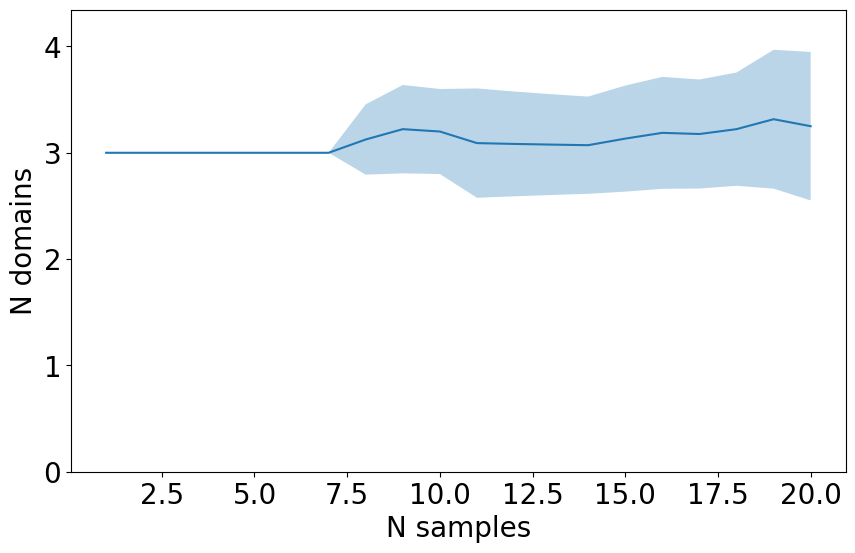

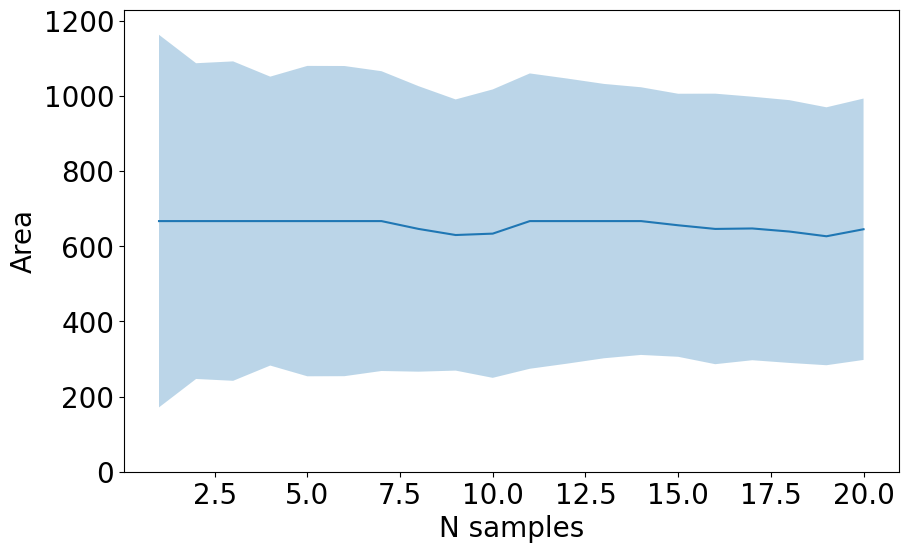

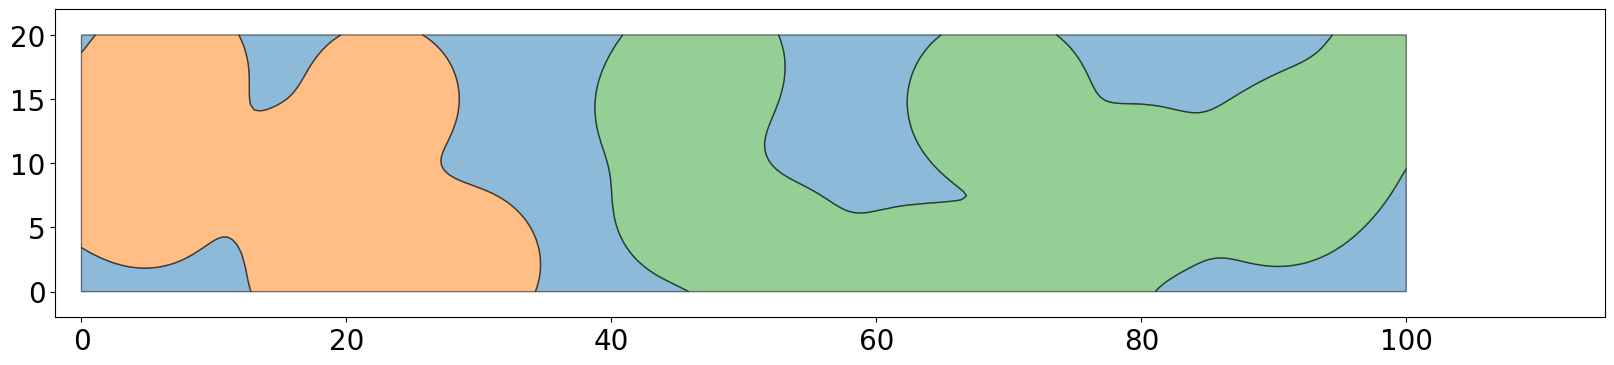

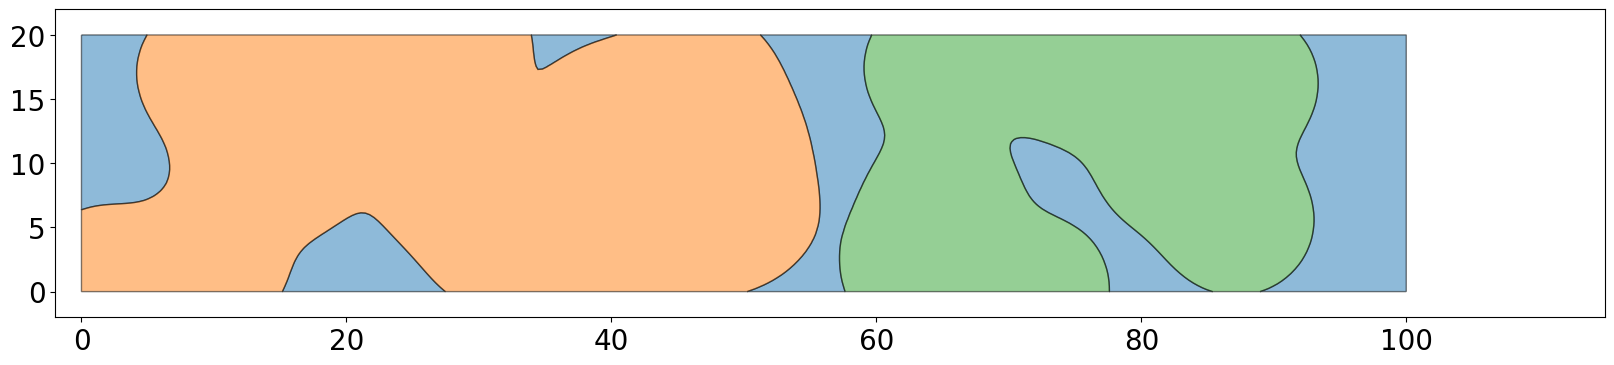

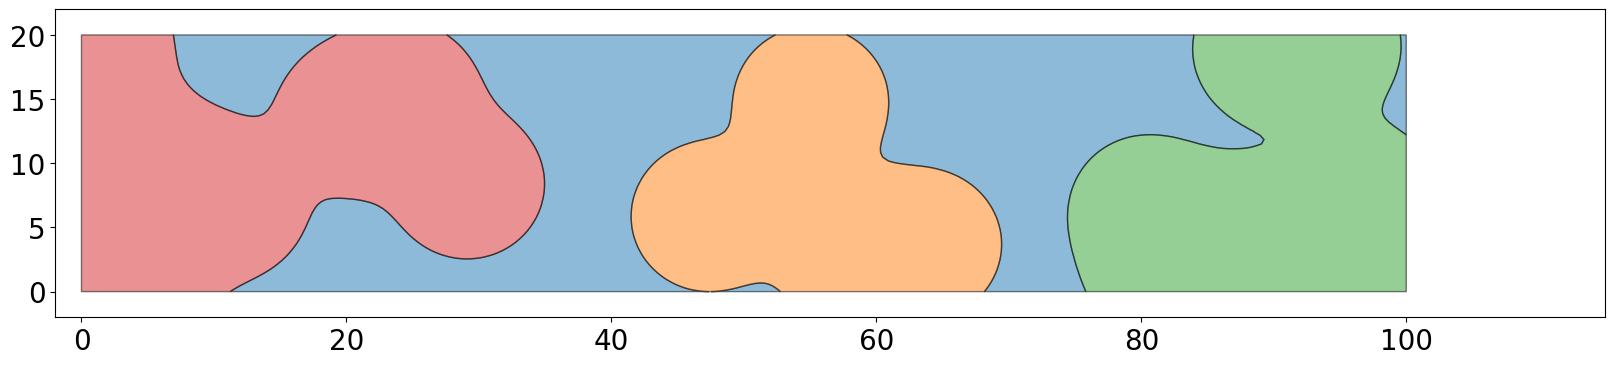

In [6]:
#*************************************************************************************************************************#
#******************************************************** Testing ********************************************************#
#*************************************************************************************************************************#


data = {
    'n_gauss' : 25,
    'n_domains' : 3,
    'n_samples' : 20,
    'sample_length' : 100.0, # Length
    'sample_width' : 20.0, # Width
    'sample_start' : [0.,0.],
    'angle' : np.radians(0),
    'sigma' : 3.,
    'contour_level' : 0.020
}

polygons_ensemble = get_polygons_ensemble(N_samples = data['n_samples'], fix_n_domains = False, 
                                          min_domain_area = -1, n_errors_tol = 15, seed = 0, timer = True, **data)
data['polygons'] = polygons_ensemble

ensemble_area_avg, ensemble_area_std, ensemble_N_domains_avg, ensemble_N_domains_std = \
get_averages_and_stds(polygons_ensemble)

plot_averages(ensemble_N_domains_avg, x_points = None, y_stds = ensemble_N_domains_std, ylabel = 'N domains', xlabel = 'N samples')
plot_averages(ensemble_area_avg, x_points = None, y_stds = ensemble_area_std, ylabel = 'Area', xlabel = 'N samples')

plot_polygons_ensemble(fpath = None, no_plots = 3, randomize_samples = True, **data)

## - Generate and store ensembles of samples

In [11]:
#****************************************************************************************************************#
#*********************************** Generate and store ensembles of polygons ***********************************#
#****************************************************************************************************************#

# Good parameters:

# n_domains --> 3 n_gauss --> 23 Sigma --> 5.0 Contour level --> 0.09
# n_domains --> 5 n_gauss --> 26 Sigma --> 2.0 Contour level --> 0.01
# n_domains --> 7 n_gauss --> 40 Sigma --> 2.0 Contour level --> 0.05


cwd = os.getcwd()

N_domains = 3
n_gauss = 23
n_samples = 30
contour_level = 0.09
sigma = 5.0


data_dir = os.path.dirname(os.getcwd()) + '/Data/Selected polygon ensembles/Test/'

data = {
    'n_gauss' : n_gauss,
    'n_domains' : N_domains,
    'n_samples' : n_samples,
    'sample_length' : 100.0, # Length
    'sample_width' : 20.0, # Width
    'sample_start' : [0.,0.],
    'angle' : np.radians(0),
    'sigma' : sigma,
    'contour_level' : contour_level
}

min_domain_area = data['sample_length'] * data['sample_width'] * 0.2 / N_domains
polygons_ensemble = get_polygons_ensemble(N_samples = data['n_samples'], fix_n_domains = True,\
                                          min_domain_area = min_domain_area , n_errors_tol = 10, seed = N_domains, timer = True, **data)
data['polygons'] = polygons_ensemble

fname = data_dir + 'data_polygon_ensemble_N_domains={}.npy'.format(N_domains) 

np.save(fname, data)



Generating the ensembles took: 0:09:22


## - Visualize stored samples

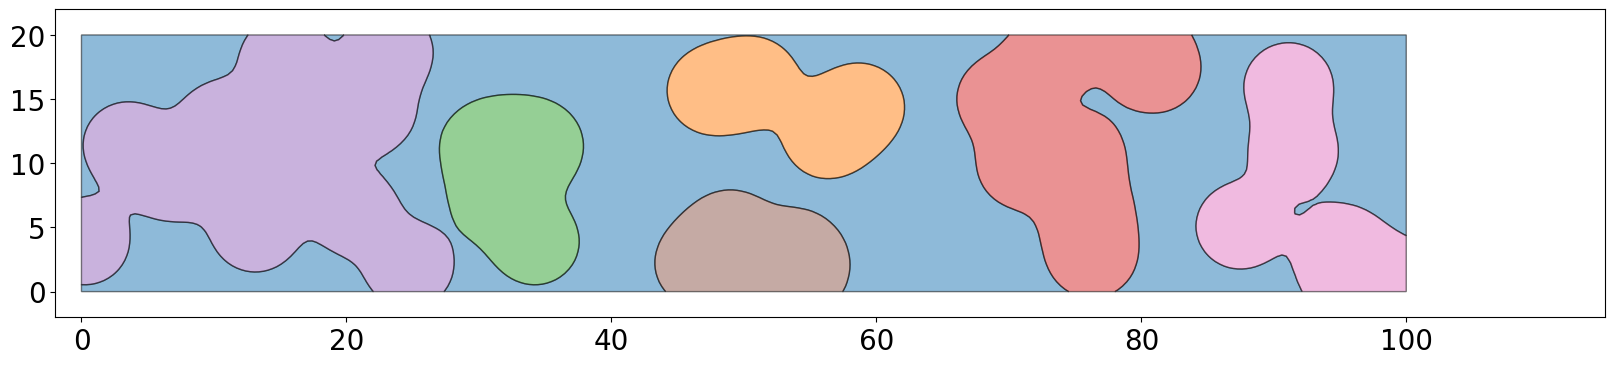

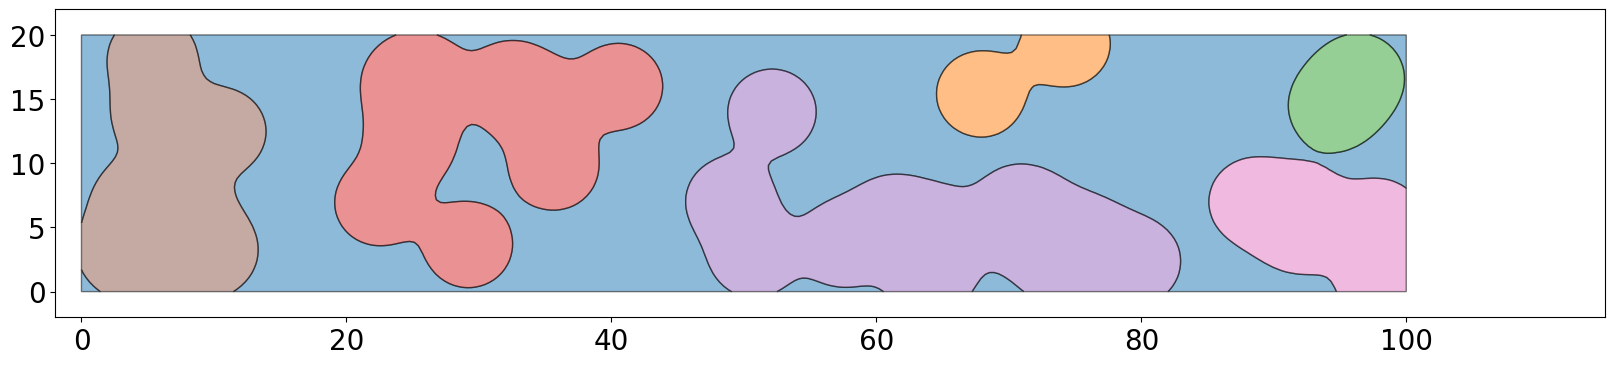

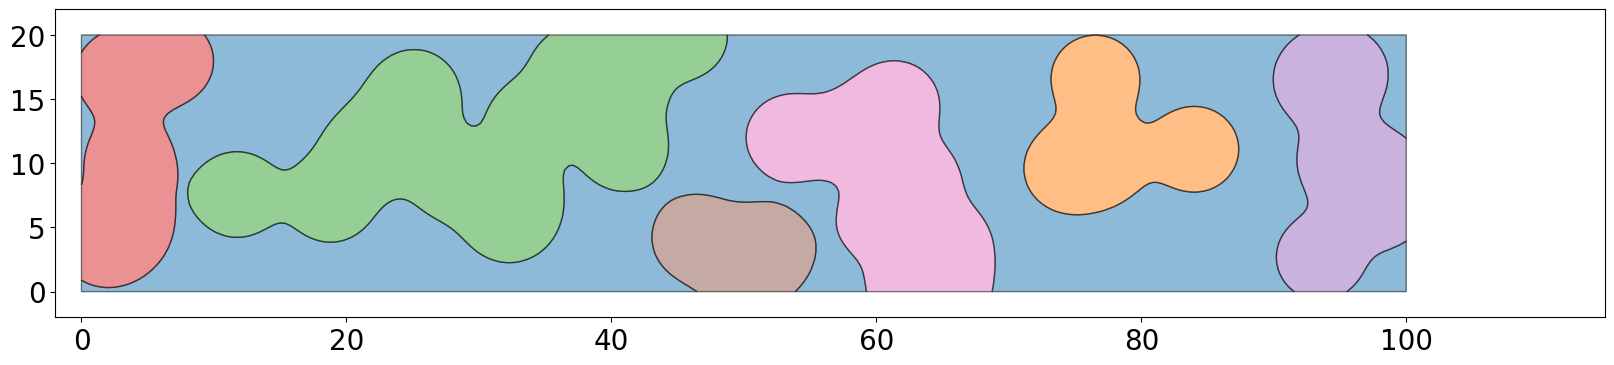

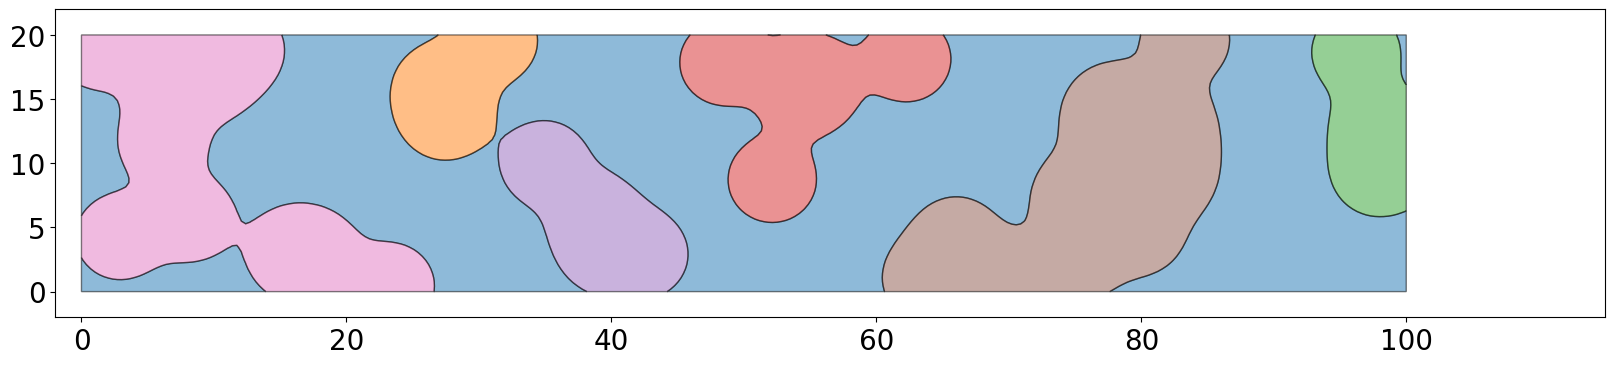

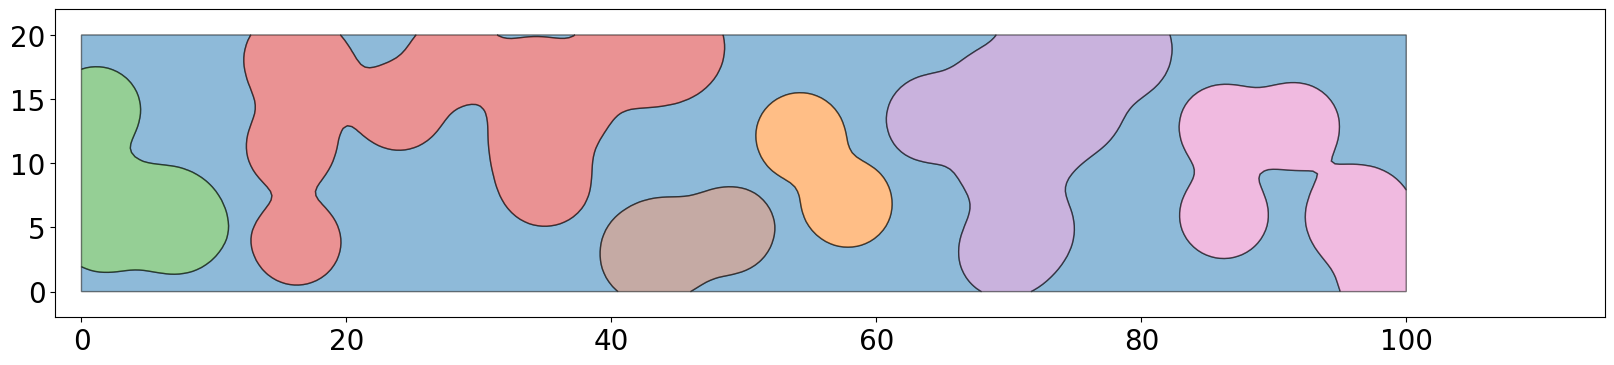

In [7]:
#**************************************************************************************************************************#
#********************************************* Show an ensemble from a folder *********************************************#
#**************************************************************************************************************************#


N_domains = 7
fpath = f"{os.path.dirname(os.getcwd())}/Data/Selected polygon ensembles/N_domains = {N_domains}/data"

plot_polygons_ensemble(fpath = fpath, no_plots = 5, randomize_samples=False)


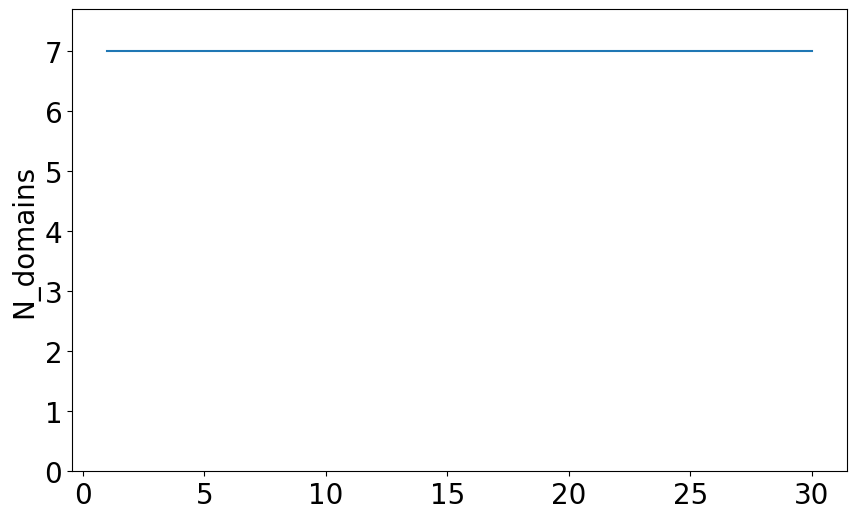

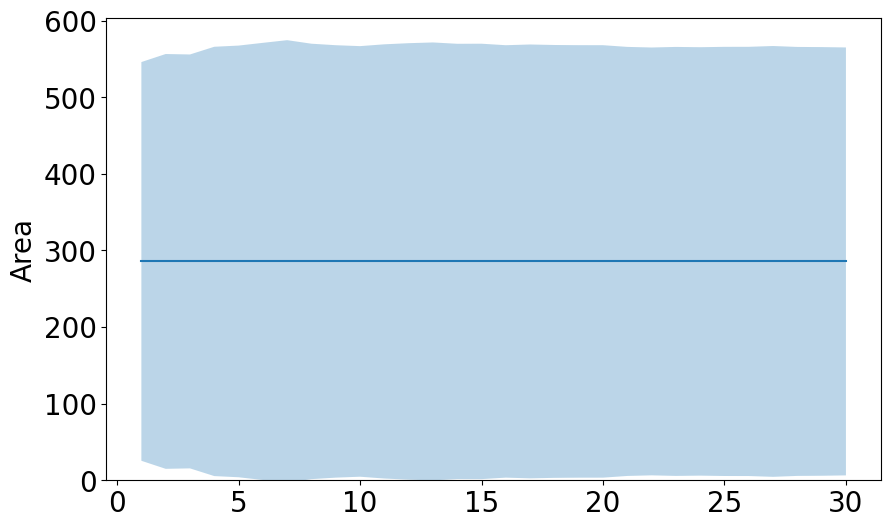

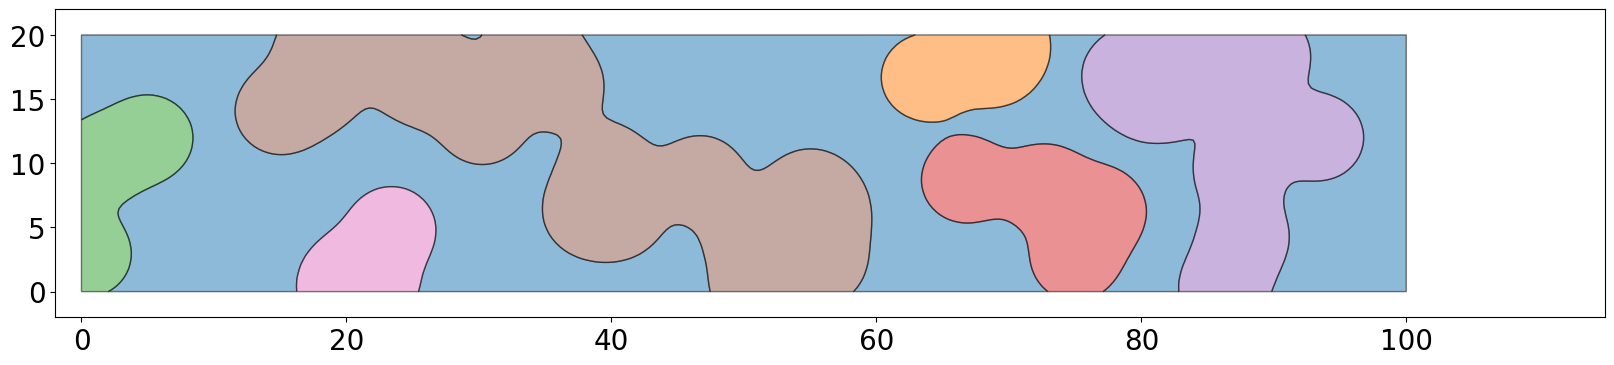

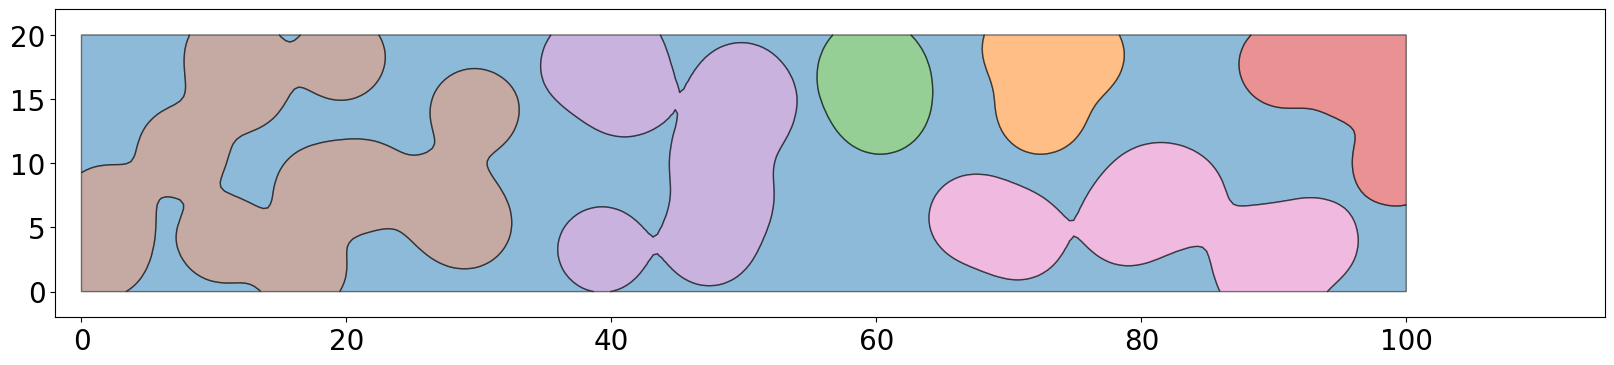

In [8]:
#**************************************************************************************************************************#
#************************************************** Show good ensembles ***************************************************#
#**************************************************************************************************************************#

cwd = os.getcwd()

N_domains = 7

fname = f"{os.path.dirname(os.getcwd())}/Data/Selected polygon ensembles/N_domains = {N_domains}/data"

data = np.load(fname, allow_pickle = True)
polygons_ensemble = data['polygons']

ensemble_area_avg, ensemble_area_std, ensemble_N_domains_avg, ensemble_N_domains_std = \
get_averages_and_stds(polygons_ensemble)

plot_averages(ensemble_N_domains_avg, x_points = None, y_stds = ensemble_N_domains_std, ylabel = 'N_domains')
plot_averages(ensemble_area_avg, x_points = None, y_stds = ensemble_area_std, ylabel = 'Area')
plot_polygons_ensemble(fpath = None, no_plots = 2, **data)



## - Extract good ensembles (those minimizing the variance in area of the domains)

In [9]:
#**************************************************************************************************************************#
#******************************** Analyze ensembles and extract good parameters from files ********************************#
#**************************************************************************************************************************#


def extract_good_ensembles(n_gauss_array, N_domains_lims = (4,8)):
    
    """ Extract the best ensembles (those that minimize the area variance in relation to the average).
    
    Parameters:
    -----------
    n_gauss_array: 1D list
        array with the range of numbers of Gaussians 
    N_domains_lims: 1D tuple or list
        minimum and maximum of the average number of Gaussians to consider
    
    Returns:
    --------
    parameters: list
        Sorted numbers, widths, and contour levels of the Gaussians (from better to worse) of the ensembles
    statistics: list
        Sorted area averages and standard deviations, and sorted number of domains average and standard deviations
    """ 

    files_dir = os.getcwd() + '/Data/Polygon ensembles'
    
    area_avgs, area_stds, N_domains_avgs, N_domains_stds = [], [], [], []
    n_gausses, sigmas, contour_levels = [], [], []
    
    for n_gauss in n_gauss_array:

        polygon_ensembles_dir = files_dir + '/n_gauss={}/'.format(n_gauss)

        files = Path(polygon_ensembles_dir)

        for file in files.iterdir():

            if os.path.isdir(file):
                print('Some directory has been found: ' + file)
                continue

            data = np.load(file, allow_pickle = True).item()

            area_avg, area_std, N_domains_avg, N_domains_std = get_averages_and_stds(data['polygons'])

            if not N_domains_lims[0] < N_domains_avg[-1] < N_domains_lims[1]:
                continue

            n_gausses.append(data['n_gauss'])
            sigmas.append(data['sigma'])
            contour_levels.append(data['contour_level'])
            
            area_avgs.append(area_avg[-1])
            area_stds.append(area_std[-1])
            N_domains_avgs.append(N_domains_avg[-1])
            N_domains_stds.append(N_domains_std[-1])
            
    del data
        
    N = len(area_stds)
    area_avgs_sorted, area_stds_sorted, N_domains_avgs_sorted, N_domains_stds_sorted = [], [], [], []
    n_gausses_sorted, sigmas_sorted, contour_levels_sorted = [], [], []
    
    std_to_avg_ratios = [area_stds[i] / area_avgs[i] for i in range(N)]
    std_to_avg_ratios_sorted = np.sort(std_to_avg_ratios)
    
    for i in range(N):
        for j in range(N):
            if std_to_avg_ratios_sorted[i] != std_to_avg_ratios[j]:
                continue
            area_avgs_sorted.append(area_avgs[j])
            area_stds_sorted.append(area_stds[j])    
            N_domains_avgs_sorted.append(N_domains_avgs[j])
            N_domains_stds_sorted.append(N_domains_stds[j])
            
            n_gausses_sorted.append(n_gausses[j])
            sigmas_sorted.append(sigmas[j])
            contour_levels_sorted.append(contour_levels[j])
            break
                
    parameters = [n_gausses_sorted, sigmas_sorted, contour_levels_sorted]
    statistics = [area_avgs_sorted, area_stds_sorted, N_domains_avgs_sorted, N_domains_stds_sorted]
    
    return parameters, statistics



In [32]:
#**************************************************************************************************************************#
#******************************** Analyze ensembles and extract good parameters from files ********************************#
#**************************************************************************************************************************#

# n_gausses_array = np.arange(20,41) # Range of values of n_gauss to consider
# N_domains_lims = (4.7,5.3) # Range of N_domains to consider


# parameters, statistics = extract_good_ensembles(n_gausses_array, N_domains_lims = N_domains_lims)

# n_gausses, sigmas, contour_levels = parameters
# area_avgs, area_stds, N_domains_avgs, N_domains_stds = statistics 


# no_ensembles = 10 # Number of ensembles to plot, from best to worst
# no_plots = 5 # Number of plots per ensemble

# files_dir = os.getcwd() + '/Data/Polygon ensembles'

# for i in range(no_ensembles):
    
#     n_gauss = n_gausses[i]
#     sigma = sigmas[i]
#     contour_level = contour_levels[i]
    
#     area_avg = area_avgs[i]
#     area_std = area_stds[i]
#     N_domains_avg = N_domains_avgs[i]
#     N_domains_std = N_domains_stds[i]
    
#     print('')
#     print('#' * 120)
#     print(" n_gauss", n_gauss, sep=" --> ")
#     print(" Sigma", sigma, sep=" --> ")
#     print(" Contour level", contour_level, sep=" --> ")
#     print(" Area average --> " + str(area_avg) + u" \u00B1 " + str(area_std))
#     print(" N_domains --> " + str(N_domains_avg) + u" \u00B1 " + str(N_domains_std))
#     print('#' * 120)
#     print('')
    
#     filename = files_dir + '/n_gauss={}/sigma={:.2f}-contour_level={:.2f}.npy'.format(n_gauss, sigma, contour_level)
#     data = np.load(filename, allow_pickle = True).item()
#     polygons_ensemble = data['polygons']
    
#     area_avg_ensemble, area_std_ensemble, N_domains_avg_ensemble, N_domains_std_ensemble = \
#     get_averages_and_stds(polygons_ensemble)

#     plot_averages(ensemble_N_domains_avg, x_points = None, y_stds = ensemble_N_domains_std, ylabel = 'N_domains')
#     plot_averages(ensemble_area_avg, x_points = None, y_stds = ensemble_area_std, ylabel = 'Area')
#     plot_polygons_ensemble(polygons_ensemble, no_plots = no_plots, xlim = (-2,115), ylim = (-2,22))


## - Correct errors that arose while generating the samples

In [20]:
#*************************************************************************************************************************#
#*********************** Checking that the ensembles do not have errors and correcting if necessary **********************#
#*************************************************************************************************************************#


def check_ensemble(data, count_errors = False):
    
    """ Check if all the samples in an ensemble are well-constructed (which means that the area of all the domains equals the area
        of the whole sample).
    
    Parameters:
    -----------
    data: dict
        Data of the ensemble:
             data = {
                    'n_gauss' : ..., # Number of Gaussians 
                    'n_domains' : ..., # Number of domains 
                    'sample_length' : ..., # Length
                    'sample_width' : ..., # Width
                    'sample_start' : [...,...], # Coordinates of the bottom left vertix
                    'angle' : np.radians(...), # Parallelogram angle
                    'sigma' : ..., # STD of the Gaussians
                    'contour_level' : ...} # Contour path value
                    }
    count_errors: bool
        Return the number of errors in the ensemble instead of True/False.
        
    Returns:
    --------
    output: bool or int
        False if a discrepancy was found in the ensemble or number of samples with errors.
    """ 
    
    polygons_ensemble = data['polygons']
    area_sample = data['sample_length'] * data['sample_width']
    error_count = 0
    
    for polygons in polygons_ensemble:
        
        total_area = 0
        for polygon in polygons:
            total_area += polygon.area
            
        if not np.isclose(total_area, area_sample, atol=0.001):
            error_count += 1
            if not count_errors:
                return False 
            
    if count_errors:
        return error_count
    
    return True


def get_bad_ensembles(n_gausses_array):
    
    """ Function description.
    
    Parameters:
    -----------
    par1: data type for par1
        Description of par1
        
    Returns:
    --------
    output1: data type of output1
        Description of output1
    """ 
    
    n_errors = []
    n_gausses_bad = []
    sigmas_bad = []
    contour_levels_bad = []

    for n_gauss in n_gausses_array:

        files_dir = os.getcwd() + '/Data/Polygon ensembles/n_gauss={}'.format(n_gauss)

        files = Path(files_dir)


        for file in files.iterdir():

            if os.path.isdir(file):
                print('Some directory has been found: ' + file)
                continue

            data = np.load(file, allow_pickle = True).item()     
            errors = count_errors(data)

            if errors > 0:
                n_errors.append(errors)
                n_gausses_bad.append(data['n_gauss'])
                sigmas_bad.append(data['sigma'])
                contour_levels_bad.append(data['contour_level'])
                
    return n_errors, n_gausses_bad, sigmas_bad, contour_levels_bad

def fix_bad_ensemble(n_gauss_bad, sigma_bad, contour_level_bad):
    
    """ Function description.
    
    Parameters:
    -----------
    par1: data type for par1
        Description of par1
        
    Returns:
    --------
    output1: data type of output1
        Description of output1
    """ 
    
    filename = os.getcwd() + '/Data/Polygon ensembles/n_gauss={}'.format(n_gauss_bad) + \
    '/sigma={:.2f}-contour_level={:.2f}.npy'.format(sigma_bad, contour_level_bad)
    
    data = np.load(filename, allow_pickle = True).item()
    
    if check_ensemble(data):
        print('Error: The polygons ensemble is not bad!')
        return None
        
    polygons_ensemble = get_polygons_ensemble(N_samples = data['n_samples'], n_errors_tol = 5, timer = True, plot_samples = False, **data)
    
    data['polygons'] = polygons_ensemble
    
    if not check_ensemble(data):
        print('Error: The new ensemble was found to be bad as well!')
        return None
    
    np.save(filename, data)

    
    

## - Making sure the stored data has no errors. The output of this cell should be an empty DataFrame

In [21]:
#************************************************************************************************************************************#
#******************************************************* Fixing bad ensembles *******************************************************#
#************************************************************************************************************************************#


import pandas as pd

n_gausses_array = np.arange(3,43)

n_errors, n_gausses_bad, sigmas_bad, contour_levels_bad = get_bad_ensembles(n_gausses_array)

bad_ensembles_data = {
    'n_errors': n_errors,
    'n_gausses_bad': n_gausses_bad,
    'sigmas_bad': sigmas_bad,
    'contour_levels_bad': contour_levels_bad}

df = pd.DataFrame(data=bad_ensembles_data)

print(df)
for i in range(len(n_gausses_bad)):
    fix_bad_ensemble(n_gausses_bad[i], sigmas_bad[i], contour_levels_bad[i])
    
n_errors, n_gausses_bad, sigmas_bad, contour_levels_bad = get_bad_ensembles(n_gausses_array)

bad_ensembles_data = {
    'n_errors': n_errors,
    'n_gausses_bad': n_gausses_bad,
    'sigmas_bad': sigmas_bad,
    'contour_levels_bad': contour_levels_bad}

df = pd.DataFrame(data=bad_ensembles_data)
print(df)


Empty DataFrame
Columns: [n_errors, n_gausses_bad, sigmas_bad, contour_levels_bad]
Index: []
Empty DataFrame
Columns: [n_errors, n_gausses_bad, sigmas_bad, contour_levels_bad]
Index: []


In [ ]:
#**************************************************************************************************************************#
#********************************************* Show an ensemble from a folder *********************************************#
#**************************************************************************************************************************#


N_domains = 7
fpath = f"{os.path.dirname(os.getcwd())}/Data/Selected polygon ensembles/N_domains = {N_domains}/data"

plot_polygons_ensemble(fpath = fpath, no_plots = 30, randomize_samples=False)